In [2]:
import h5py
import os
import glob

import numpy as np
from scipy.stats import zscore
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from scipy.optimize import curve_fit  # Add this import statement
from scipy.signal import convolve2d
import sails

In [3]:
def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    """
    Compute the Morlet wavelet transform of a given signal using the SAILS library.

    Parameters:
    - x (numpy.ndarray): The input signal.
    - sample_rate (int): The rate at which the signal is sampled.
    - frequencies (numpy.ndarray, optional): The array of frequencies at which to compute the transform
      (default is from 1 to 200 Hz).
    - n (int, optional): The number of cycles in the Morlet wavelet (default is 5).
    - mode (str, optional): The mode of the return, whether 'complex', 'power', or 'amplitude'
      (default is 'complex').
      
    Returns:
    - numpy.ndarray: The computed Morlet wavelet transform of the input signal.

    Note:
    - This function relies on the SAILS library to perform the wavelet transform.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.sin(2 * np.pi * 10 * np.arange(0, 1, 1/sample_rate))
    wt_result = morlet_wt(signal, sample_rate)
    print(wt_result)
    ```
    """
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    # Return the computed wavelet transform.
    return wavelet_transform
# The tg_split function categorizes frequency values into three groups: sub-theta, theta, and supra-theta.
def tg_split(mask_freq, theta_range=(5, 12)):
    """
    Categorize frequency values into three groups: sub-theta, theta, and supra-theta.

    Parameters:
    - mask_freq (numpy.ndarray): An array of frequency values that you want to categorize.
    - theta_range (tuple, optional): A range of frequencies considered as the theta band
      (default is (5, 12) Hz).

    Returns:
    - tuple: A tuple containing three boolean masks representing sub-theta, theta, and supra-theta categories.

    Example:
    ```python
    import numpy as np

    # Example usage:
    freq_values = np.array([3, 8, 10, 15, 20])
    sub_mask, theta_mask, supra_mask = tg_split(freq_values)
    print("Sub-theta frequencies:", freq_values[sub_mask])
    print("Theta frequencies:", freq_values[theta_mask])
    print("Supra-theta frequencies:", freq_values[supra_mask])
    ```
    """
    # Get the lower and upper bounds of the theta range.
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    # Create a boolean mask for frequencies within the theta range.
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    # Create boolean masks for frequencies below and above the theta range.
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    # Assign the boolean masks to variables for each category.
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index
    # Return the boolean masks for sub-theta, theta, and supra-theta categories.
    return sub, theta, supra

def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

def adaptive_threshold(data, window_size):
    std_values = np.zeros_like(data)
    
    for i in range(len(data)):
        start = max(0, i - window_size)
        end = min(len(data), i + window_size)
        std_values[i] = np.std(data[start:end])

    return std_values
def boxcar_smooth(x, boxcar_window):
    """
    Smooth a 1D or 2D array using a boxcar window.

    Parameters:
    - x (numpy.ndarray): Input array to be smoothed.
    - boxcar_window (int or tuple): Size of the boxcar window for smoothing.
      For 1D array, an integer representing the window size.
      For 2D array, a tuple (t, f) representing window sizes along the time (t) and frequency (f) dimensions.

    Returns:
    - numpy.ndarray: Smoothed array using the boxcar window.

    Notes:
    - If the input array is 1D, the boxcar window size is adjusted to be odd.
    - If the input array is 2D, separate boxcar windows are created for the time (t) and frequency (f) dimensions.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal_1d = np.random.rand(100)  # Replace with your actual 1D signal
    window_size_1d = 5
    smoothed_1d = boxcar_smooth(signal_1d, window_size_1d)
    print(smoothed_1d)

    signal_2d = np.random.rand(100, 50)  # Replace with your actual 2D signal
    window_size_2d = (5, 3)
    smoothed_2d = boxcar_smooth(signal_2d, window_size_2d)
    print(smoothed_2d)
    ```
    """
    # Check if the input array x is 1-dimensional
    if x.ndim == 1:
        # Check if the boxcar window size is even, and if so, make it odd by adding 1
        if boxcar_window % 2 == 0:
            boxcar_window += 1
        # Create a boxcar window of size boxcar_window for smoothing
        window = np.ones((1, boxcar_window)) / boxcar_window
        # Perform 1-dimensional convolution to smooth the input array x
        x_spectrum = np.convolve(x, window, mode='same')
    else:
        # Adjust the boxcar window size to be odd for both dimensions
        bool_window = np.where(~np.array(boxcar_window) % 2 == 0, boxcar_window, np.array(boxcar_window) + 1)
        # Create separate boxcar windows for time (t) and frequency (f) dimensions
        window_t = np.ones((1, bool_window[0])) / bool_window[0]
        window_f = np.ones((1, bool_window[1])) / bool_window[1]
        # Perform 2-dimensional convolution first along the time dimension (t)
        x_spectrum_t = convolve2d(x, window_t, mode='same')
        # Perform 2-dimensional convolution along the frequency dimension (f)
        x_spectrum = convolve2d(x_spectrum_t, window_f.T, mode='same')
    # Return the smoothed array x_spectrum
    return x_spectrum

Processing data in folder: E:\Donders\1\processed
Processing subfolder: CN
Processing dataset folder: post_trial1_2017-09-28_11-30-59
Processing HDF5 file: E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5
Processing group: post_trial1_2017-09-28_11-30-59
(212501, 6)
shape power matrix: (125, 212501)
shape of fpp_plots (610, 125, 19)
Processing dataset folder: post_trial2_2017-09-28_12-21-41
Processing HDF5 file: E:\Donders\1\processed\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41_REM_dict.h5
Processing group: post_trial2_2017-09-28_12-21-41
(157501, 6)
shape power matrix: (125, 157501)
shape of fpp_plots (416, 125, 19)
Processing dataset folder: post_trial3_2017-09-28_13-12-53
Processing HDF5 file: E:\Donders\1\processed\CN\post_trial3_2017-09-28_13-12-53\post_trial3_2017-09-28_13-12-53_REM_dict.h5
Processing group: post_trial3_2017-09-28_13-12-53
(52501, 6)
shape power matrix: (125, 52501)
shape of fpp_plots (14

shape power matrix: (125, 465001)
shape of fpp_plots (1292, 125, 19)
(527501, 6)
shape power matrix: (125, 527501)
shape of fpp_plots (1452, 125, 19)
Processing dataset folder: post_trial5_2017-09-21_14-31-51
Processing HDF5 file: E:\Donders\1\processed\OD\post_trial5_2017-09-21_14-31-51\post_trial5_2017-09-21_14-31-51_REM_dict.h5
Processing group: post_trial5_2017-09-21_14-31-51
(602501, 6)
shape power matrix: (125, 602501)
shape of fpp_plots (1592, 125, 19)
(122501, 6)
shape power matrix: (125, 122501)
shape of fpp_plots (368, 125, 19)
(40001, 6)
shape power matrix: (125, 40001)
shape of fpp_plots (96, 125, 19)
(80001, 6)
shape power matrix: (125, 80001)
shape of fpp_plots (211, 125, 19)
(260001, 6)
shape power matrix: (125, 260001)
shape of fpp_plots (735, 125, 19)
(702501, 6)
shape power matrix: (125, 702501)
shape of fpp_plots (1761, 125, 19)
(170001, 6)
shape power matrix: (125, 170001)
shape of fpp_plots (453, 125, 19)
(197501, 6)
shape power matrix: (125, 197501)
shape of fpp_p

shape power matrix: (125, 50001)
shape of fpp_plots (134, 125, 19)
(412501, 6)
shape power matrix: (125, 412501)
shape of fpp_plots (1147, 125, 19)
(297501, 6)
shape power matrix: (125, 297501)
shape of fpp_plots (863, 125, 19)
(195001, 6)
shape power matrix: (125, 195001)
shape of fpp_plots (425, 125, 19)
(447501, 6)
shape power matrix: (125, 447501)
shape of fpp_plots (1255, 125, 19)
(45001, 6)
shape power matrix: (125, 45001)
shape of fpp_plots (120, 125, 19)
(190001, 6)
shape power matrix: (125, 190001)
shape of fpp_plots (531, 125, 19)
(105001, 6)
shape power matrix: (125, 105001)
shape of fpp_plots (309, 125, 19)
(337501, 6)
shape power matrix: (125, 337501)
shape of fpp_plots (981, 125, 19)
(102501, 6)
shape power matrix: (125, 102501)
shape of fpp_plots (314, 125, 19)
(12501, 6)
shape power matrix: (125, 12501)
shape of fpp_plots (32, 125, 19)
(340001, 6)
shape power matrix: (125, 340001)
shape of fpp_plots (949, 125, 19)
(377501, 6)
shape power matrix: (125, 377501)
shape of f

shape power matrix: (125, 182501)
shape of fpp_plots (195, 125, 19)
Processing dataset folder: post_trial5_2017-11-08_16-18-24
Processing HDF5 file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD1_OR_08-09_11_2017\post_trial5_2017-11-08_16-18-24\post_trial5_2017-11-08_16-18-24_REM_dict.h5
Processing group: post_trial5_2017-11-08_16-18-24
(37501, 6)
shape power matrix: (125, 37501)
shape of fpp_plots (50, 125, 19)
(25001, 6)
shape power matrix: (125, 25001)
shape of fpp_plots (47, 125, 19)
(277501, 6)
shape power matrix: (125, 277501)
shape of fpp_plots (388, 125, 19)
(245001, 6)
shape power matrix: (125, 245001)
shape of fpp_plots (537, 125, 19)
(117501, 6)
shape power matrix: (125, 117501)
shape of fpp_plots (116, 125, 19)
(45001, 6)
shape power matrix: (125, 45001)
shape of fpp_plots (62, 125, 19)
(20001, 6)
shape power matrix: (125, 20001)
shape of fpp_plots (26, 125, 19)
(255001, 6)
shape power matrix: (125, 255001)
shape of fpp_plots (268, 125, 19)
(15001, 6)
shape power matrix: (125

shape power matrix: (125, 100001)
shape of fpp_plots (241, 125, 19)
(117501, 6)
shape power matrix: (125, 117501)
shape of fpp_plots (298, 125, 19)
(40001, 6)
shape power matrix: (125, 40001)
shape of fpp_plots (118, 125, 19)
(85001, 6)
shape power matrix: (125, 85001)
shape of fpp_plots (153, 125, 19)
Processing dataset folder: post_trial3_2017-11-23_12-33-48
Processing HDF5 file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD6_HC_23_11_2017\post_trial3_2017-11-23_12-33-48\post_trial3_2017-11-23_12-33-48_REM_dict.h5
Processing group: post_trial3_2017-11-23_12-33-48
(365001, 6)
shape power matrix: (125, 365001)
shape of fpp_plots (922, 125, 19)
Processing dataset folder: post_trial4_2017-11-23_13-24-05
Processing HDF5 file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD6_HC_23_11_2017\post_trial4_2017-11-23_13-24-05\post_trial4_2017-11-23_13-24-05_REM_dict.h5
Processing group: post_trial4_2017-11-23_13-24-05
(365001, 6)
shape power matrix: (125, 365001)
shape of fpp_plots (234, 125, 19)
(600

shape of fpp_plots (496, 125, 19)
(55000, 6)
shape power matrix: (125, 55000)
shape of fpp_plots (138, 125, 19)
(150000, 6)
shape power matrix: (125, 150000)
shape of fpp_plots (347, 125, 19)
(310000, 6)
shape power matrix: (125, 310000)
shape of fpp_plots (887, 125, 19)
(242500, 6)
shape power matrix: (125, 242500)
shape of fpp_plots (544, 125, 19)
(40000, 6)
shape power matrix: (125, 40000)
shape of fpp_plots (78, 125, 19)
Processing dataset folder: presleep_2017-12-21_11-48-07
Processing HDF5 file: E:\Donders\4\processed\OD\presleep_2017-12-21_11-48-07\presleep_2017-12-21_11-48-07_REM_dict.h5
Processing group: presleep_2017-12-21_11-48-07
Processing subfolder: Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017
Processing dataset folder: post_trial1_2017-12-13_09-11-31
Processing HDF5 file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial1_2017-12-13_09-11-31\post_trial1_2017-12-13_09-11-31_REM_dict.h5
Processing group: post_trial1_2017-12-13_09-11-31
Processing dataset folder:

shape power matrix: (125, 212500)
shape of fpp_plots (426, 125, 19)
(327500, 6)
shape power matrix: (125, 327500)
shape of fpp_plots (723, 125, 19)
(212500, 6)
shape power matrix: (125, 212500)
shape of fpp_plots (426, 125, 19)
(327500, 6)
shape power matrix: (125, 327500)
shape of fpp_plots (723, 125, 19)
Processing dataset folder: post_trial5_2017-12-18_14-30-11
Processing HDF5 file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD4_OR_N_18-19_12_2017\post_trial5_2017-12-18_14-30-11\post_trial5_2017-12-18_14-30-11_REM_dict.h5
Processing group: post_trial5_2017-12-18_14-30-11
(282500, 6)
shape power matrix: (125, 282500)
shape of fpp_plots (527, 125, 19)
(230000, 6)
shape power matrix: (125, 230000)
shape of fpp_plots (258, 125, 19)
(135000, 6)
shape power matrix: (125, 135000)
shape of fpp_plots (307, 125, 19)
(82500, 6)
shape power matrix: (125, 82500)
shape of fpp_plots (67, 125, 19)
(350000, 6)
shape power matrix: (125, 350000)
shape of fpp_plots (721, 125, 19)
(322500, 6)
shape power 

Processing subfolder: 2018_06_27_Study_day_16_or_nov
Processing dataset folder: 2018-06-27_09-13-35_pre-sleep
Processing HDF5 file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_09-13-35_pre-sleep\2018-06-27_09-13-35_pre-sleep_REM_dict.h5
Processing group: 2018-06-27_09-13-35_pre-sleep
Processing dataset folder: 2018-06-27_10-04-32_Post_Trial1
Processing HDF5 file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_10-04-32_Post_Trial1\2018-06-27_10-04-32_Post_Trial1_REM_dict.h5
Processing group: 2018-06-27_10-04-32_Post_Trial1
Processing dataset folder: 2018-06-27_10-55-01_Post_Trial2
Processing HDF5 file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_10-55-01_Post_Trial2\2018-06-27_10-55-01_Post_Trial2_REM_dict.h5
Processing group: 2018-06-27_10-55-01_Post_Trial2
Processing dataset folder: 2018-06-27_11-45-36_Post_Trial3
Processing HDF5 file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_11-45-36_Post_Trial3\2018-

shape of fpp_plots (288, 125, 19)
Processing dataset folder: 2018-05-13_12-16-38_Post_Trial3
Processing HDF5 file: E:\Donders\9\processed\HC\2018-05-13_12-16-38_Post_Trial3\2018-05-13_12-16-38_Post_Trial3_REM_dict.h5
Processing group: 2018-05-13_12-16-38_Post_Trial3
(147500, 6)
shape power matrix: (125, 147500)
shape of fpp_plots (393, 125, 19)
(345000, 6)
shape power matrix: (125, 345000)
shape of fpp_plots (937, 125, 19)
(175000, 6)
shape power matrix: (125, 175000)
shape of fpp_plots (482, 125, 19)
(365000, 6)
shape power matrix: (125, 365000)
shape of fpp_plots (1004, 125, 19)
(107500, 6)
shape power matrix: (125, 107500)
shape of fpp_plots (285, 125, 19)
Processing dataset folder: 2018-05-13_13-07-00_Post_Trial4
Processing HDF5 file: E:\Donders\9\processed\HC\2018-05-13_13-07-00_Post_Trial4\2018-05-13_13-07-00_Post_Trial4_REM_dict.h5
Processing group: 2018-05-13_13-07-00_Post_Trial4
(277500, 6)
shape power matrix: (125, 277500)
shape of fpp_plots (733, 125, 19)
Processing dataset 

shape power matrix: (125, 375000)
shape of fpp_plots (670, 125, 19)
(130000, 6)
shape power matrix: (125, 130000)
shape of fpp_plots (258, 125, 19)
Processing dataset folder: 2018-10-29_13-32-18_Post_Trial3
Processing HDF5 file: E:\Donders\11\processed\CN\2018-10-29_13-32-18_Post_Trial3\2018-10-29_13-32-18_Post_Trial3_REM_dict.h5
Processing group: 2018-10-29_13-32-18_Post_Trial3
(127500, 6)
shape power matrix: (125, 127500)
shape of fpp_plots (267, 125, 19)
(522500, 6)
shape power matrix: (125, 522500)
shape of fpp_plots (1129, 125, 19)
(60000, 6)
shape power matrix: (125, 60000)
shape of fpp_plots (123, 125, 19)
(412500, 6)
shape power matrix: (125, 412500)
shape of fpp_plots (843, 125, 19)
Processing dataset folder: 2018-10-29_14-22-53_Post_Trial4
Processing HDF5 file: E:\Donders\11\processed\CN\2018-10-29_14-22-53_Post_Trial4\2018-10-29_14-22-53_Post_Trial4_REM_dict.h5
Processing group: 2018-10-29_14-22-53_Post_Trial4
(230000, 6)
shape power matrix: (125, 230000)
shape of fpp_plots 

shape of fpp_plots (290, 125, 19)
Processing dataset folder: 2018-10-31_12-06-31_Post_Trial2
Processing HDF5 file: E:\Donders\11\processed\OD\2018-10-31_12-06-31_Post_Trial2\2018-10-31_12-06-31_Post_Trial2_REM_dict.h5
Processing group: 2018-10-31_12-06-31_Post_Trial2
(220000, 6)
shape power matrix: (125, 220000)
shape of fpp_plots (273, 125, 19)
(357500, 6)
shape power matrix: (125, 357500)
shape of fpp_plots (474, 125, 19)
(62500, 6)
shape power matrix: (125, 62500)
shape of fpp_plots (76, 125, 19)
(190000, 6)
shape power matrix: (125, 190000)
shape of fpp_plots (244, 125, 19)
Processing dataset folder: 2018-10-31_12-57-33_Post_Trial3
Processing HDF5 file: E:\Donders\11\processed\OD\2018-10-31_12-57-33_Post_Trial3\2018-10-31_12-57-33_Post_Trial3_REM_dict.h5
Processing group: 2018-10-31_12-57-33_Post_Trial3
(365000, 6)
shape power matrix: (125, 365000)
shape of fpp_plots (174, 125, 19)
(110000, 6)
shape power matrix: (125, 110000)
shape of fpp_plots (26, 125, 19)
(50000, 6)
shape power

Processing group: 2019-05-13_10-32-56_presleep
Processing dataset folder: 2019-05-13_11-24-48_post_trial1
Processing HDF5 file: E:\Donders\13\processed\CN\2019-05-13_11-24-48_post_trial1\2019-05-13_11-24-48_post_trial1_REM_dict.h5
Processing group: 2019-05-13_11-24-48_post_trial1
(25000, 6)
shape power matrix: (125, 25000)
shape of fpp_plots (55, 125, 19)
Processing dataset folder: 2019-05-13_12-15-25_post_trial2
Processing HDF5 file: E:\Donders\13\processed\CN\2019-05-13_12-15-25_post_trial2\2019-05-13_12-15-25_post_trial2_REM_dict.h5
Processing group: 2019-05-13_12-15-25_post_trial2
(327500, 6)
shape power matrix: (125, 327500)
shape of fpp_plots (950, 125, 19)
(160000, 6)
shape power matrix: (125, 160000)
shape of fpp_plots (451, 125, 19)
Processing dataset folder: 2019-05-13_13-05-57_post_trial3
Processing HDF5 file: E:\Donders\13\processed\CN\2019-05-13_13-05-57_post_trial3\2019-05-13_13-05-57_post_trial3_REM_dict.h5
Processing group: 2019-05-13_13-05-57_post_trial3
(15000, 6)
sha

Processing group: 2019-05-15_10-47-11_post_trial1
Processing dataset folder: 2019-05-15_11-37-30_post_trial2
Processing HDF5 file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019\2019-05-15_11-37-30_post_trial2\2019-05-15_11-37-30_post_trial2_REM_dict.h5
Processing group: 2019-05-15_11-37-30_post_trial2
(182500, 6)
shape power matrix: (125, 182500)
shape of fpp_plots (393, 125, 19)
(165000, 6)
shape power matrix: (125, 165000)
shape of fpp_plots (426, 125, 19)
(282500, 6)
shape power matrix: (125, 282500)
shape of fpp_plots (714, 125, 19)
(7500, 6)
shape power matrix: (125, 7500)
shape of fpp_plots (16, 125, 19)
Processing dataset folder: 2019-05-15_12-27-45_post_trial3
Processing HDF5 file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD2_HC_15_05_2019\2019-05-15_12-27-45_post_trial3\2019-05-15_12-27-45_post_trial3_REM_dict.h5
Processing group: 2019-05-15_12-27-45_post_trial3
(225000, 6)
shape power matrix: (125, 225000)
shape of fpp_plots (479, 125, 19)
(9250

shape of fpp_plots (926, 125, 19)
(340000, 6)
shape power matrix: (125, 340000)
shape of fpp_plots (971, 125, 19)
(72500, 6)
shape power matrix: (125, 72500)
shape of fpp_plots (202, 125, 19)
Number of HC data arrays: 161
Number of OD data arrays: 161
Number of OR data arrays: 223
Number of OR_N data arrays: 61
Number of CN data arrays: 147


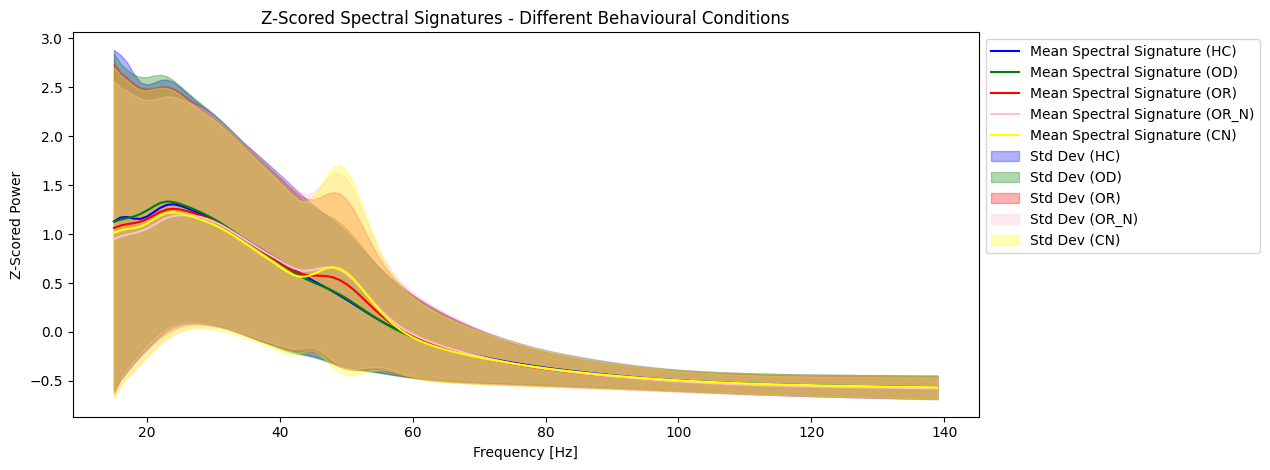

In [9]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore


# Define the root folder containing '1', '2', '3', etc.
root_folder = r"E:\Donders"

# Define the target folders (numerical)
target_folders = ['1', '3','4', '9', '11', '13']
frequencies = np.arange(15, 140, 1)
 # Initialize an empty array to accumulate mean power arrays
# Create dictionaries to store power lists for different conditions
power_lists = {"HC": [], "OD": [], "OR": [], "OR_N": [], "CN": []}
for target_folder in target_folders:
    # Construct the path to the processed folder
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Check if the processed folder exists
    if os.path.exists(processed_folder):
        print(f"Processing data in folder: {processed_folder}")

        # Iterate through subfolders in processed folder
        for subfolder in os.listdir(processed_folder):
            subfolder_path = os.path.join(processed_folder, subfolder)

            # Check if it's a directory and contains "HC"
            if os.path.isdir(subfolder_path):
                print(f"Processing subfolder: {subfolder}")

                # Iterate through sub-subfolders (containing datasets)
                for dataset_folder in os.listdir(subfolder_path):
                    dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                    # Check if it's a directory
                    if os.path.isdir(dataset_folder_path):
                        print(f"Processing dataset folder: {dataset_folder}")

                        # Use glob to get all .h5 files in the dataset folder
                        hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                        # Iterate over each .h5 file
                        for hdf5_file_path in hdf5_files:
                            print(f"Processing HDF5 file: {hdf5_file_path}")

                            # Open the HDF5 file in read mode
                            with h5py.File(hdf5_file_path, 'r') as hdf_file:
                                # Iterate over all groups in the file
                                for group_name in hdf_file.keys():
                                    print(f"Processing group: {group_name}")

                                    # Access the current group
                                    current_group = hdf_file[group_name]

                                    rem_dict_keys = list(current_group.keys())
                                   
                                   


                                    # Iterate over conditions
                                    for condition_key in power_lists.keys():
                                        for rem_key in rem_dict_keys:
                                            # Check if the current condition is present in the subfolder name
                                            if condition_key in subfolder:
                                                imfs = current_group[rem_key]['IMFs'] 
                                                print(imfs.shape)
                                                # Identify the indices of theta frequencies in the 'IMFs' array
                                                theta_range = (5, 12)
                                                sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], theta_range)

                                                # Extract IMFs corresponding to theta signals and sum them up
                                                supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)

                                                # Access the 'wavelet_transform' key for the current REM period
                                                wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequencies, n=5, mode='amplitude')
                                                # Square each value in the matrix to get power
                                                power_matrix = np.square(np.abs(wavelet_transform))
                                                print("shape power matrix:", power_matrix.shape)
                                                # Z-score along the time axis
                                                power = zscore(power_matrix, axis=0)

                                                start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                                fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                                newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                                # Calculate mean power values for the subset of frequencies
                                                fpp_plots = bin_tf_to_fpp(newcycles, power, 19)
                                                print("shape of fpp_plots", fpp_plots.shape)

                                                # Check if fpp_plots is 1D before attempting to calculate the mean along axis 2
                                                if len(fpp_plots.shape) > 1:
                                                    mean_along_axis_2 = (np.mean(fpp_plots, axis=2)).T
                                                    power_lists[condition_key].append(mean_along_axis_2)
                                                else:
                                                    print(f"Error: fpp_plots is 1D. Check your data for {condition_key}.")

# Print some information about the collected data
for condition_key, power_list in power_lists.items():
    print(f"Number of {condition_key} data arrays: {len(power_list)}")

# Replace the original list comprehension for filtered_power_list
filtered_power_lists = {key: [arr for arr in power_list if len(arr.shape) > 0] for key, power_list in power_lists.items()}

# Concatenate the filtered arrays for each condition
power_arrays = {key: np.concatenate(filtered_power_list, axis=1) for key, filtered_power_list in filtered_power_lists.items()}

# Calculate the mean power across all cycles for each condition
spectral_signature_means = {key: np.mean(power_array, axis=1) for key, power_array in power_arrays.items()}

# Calculate the standard deviation across all cycles for each condition
spectral_signature_stds = {key: np.std(power_array, axis=1) for key, power_array in power_arrays.items()}

# Manually specify distinct colors for each condition
colors = ['blue', 'green', 'red', 'pink', 'yellow']

# Plot the mean power across all cycles for each condition with distinct colors
for i, (condition_key, spectral_signature_mean) in enumerate(spectral_signature_means.items()):
    plt.plot(frequencies, spectral_signature_mean, linestyle='-', label=f'Mean Spectral Signature ({condition_key})', color=colors[i])

# Fill the area between mean - std and mean + std with a translucent color for each condition
for i, (condition_key, spectral_signature_mean) in enumerate(spectral_signature_means.items()):
    plt.fill_between(frequencies, spectral_signature_mean - spectral_signature_stds[condition_key],
                     spectral_signature_mean + spectral_signature_stds[condition_key],
                     alpha=0.3, label=f'Std Dev ({condition_key})', color=colors[i])

plt.xlabel('Frequency [Hz]')
plt.ylabel('Z-Scored Power')
plt.title('Z-Scored Spectral Signatures - Different Behavioural Conditions')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the width of the plot
plt.tight_layout(rect=[0, 0, 2, 1])  # Adjust the third value to change the width

plt.show()



# Calculate the standard deviation across all cycles for both 'HC' and 'NON-HC'
#spectral_signature_std_hc = np.std(power_array_hc, axis=1)
#spectral_signature_std_non_hc = np.std(power_array_non_hc, axis=1)

# Plot the mean power across all cycles for both 'HC' and 'NON-HC'
#plt.plot(frequencies, spectral_signature_mean_hc, linestyle='-', color='red', label='Mean Spectral Signature (HC)')
#plt.plot(frequencies, spectral_signature_mean_non_hc, linestyle='--', color='blue', label='Mean Spectral Signature (NON-HC)')

# Fill the area between mean - std and mean + std with a translucent color for 'HC'
#plt.fill_between(frequencies, spectral_signature_mean_hc - spectral_signature_std_hc, spectral_signature_mean_hc + spectral_signature_std_hc, color='lightcoral', alpha=0.3, label='Std Dev (HC)')

# Fill the area between mean - std and mean + std with a translucent color for 'NON-HC'
#plt.fill_between(frequencies, spectral_signature_mean_non_hc - spectral_signature_std_non_hc, spectral_signature_mean_non_hc + spectral_signature_std_non_hc, color='lightblue', alpha=0.3, label='Std Dev (NON-HC)')

#plt.xlabel('Frequency [Hz]')
#plt.ylabel('Power')
#plt.title('Spectral Signature Comparison - Home Cage (HC) vs Non-Home Cage (NON-HC)')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.show()
